# Who Should I Train in Pokemon Sword/Shield?
### *Based on Stats and Type Vulnerabilities*

This notebook allows for interactive exploration of Pokemons in Sword/Shield, primarily focused on stats and type vulnerabilities, to answer the question: Which wild Pokemon should I invest in training to make it to the Elite Four and beat them?

It features:
* Pareto efficiency 
* Interactive data tables (with itables)
* Interactive plots (with Plotly)
* UMAP embeddings
* Z scores
* Recursion (to descend evolutionary trees)

This project was heavily inspired by [Optimizing your Pokemon Lineup with Pareto Frontier](https://medium.com/elobump/optimizing-your-pokemon-lineup-with-pareto-frontier-763d283d5d3a) by Mike Morrow (in particular using his [pareto efficiency code](https://gist.github.com/Mike-Morrow/4de00f931d72d8a6788763c2e45cf6c2)) and [The best Mario Kart character according to data science](https://medium.com/civis-analytics/the-best-mario-kart-character-according-to-data-science-7dfb65d4c18e) by Henry Hinnefeld. 

# Set up

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import pokebase as pb
from itables import init_notebook_mode
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.error import HTTPError
from IPython.display import Image
import umap
import pickle 
import pokepareto
import logging
import plotly.express as px

logging.basicConfig(level=logging.DEBUG)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [8]:
stat_names = ['attack',
              'defense',
              'sp_attack',
              'sp_defense', 
              'speed',
              'hp']
zstat_names = ["z_"+n for n in stat_names]
key_cols = ['name','pokedex_number'] + stat_names + zstat_names

# Build or Load Pokemon Sword & Shield dataset 

In [59]:
all_ss = pokepareto.load_pickle('pokemon_info.pickle')

In [10]:
%%time

## Pull Galar pokemon data from Pokemon API
# all_ss = pokepareto.build_base_pokemon_df(pokedex='galar')
# pokepareto.save_pickle(all_ss, 'pokemon_info.pickle')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


In [11]:
all_types = np.sort(all_ss.type_1.unique())

In [60]:
# Explore basic info for all Sword & Shield Pokemon 
print(all_ss.columns)
all_ss

Index(['name', 'id', 'pokedex_number', 'generation', 'is_legendary',
       'is_mythical', 'species_id', 'hp', 'attack', 'defense', 'sp_attack',
       'sp_defense', 'speed', 'type_1', 'type_2'],
      dtype='object')


name,id,pokedex_number,generation,is_legendary,is_mythical,species_id,hp,attack,defense,sp_attack,sp_defense,speed,type_1,type_2


# Type vulnerabilities

In [13]:
# Load type-type vulnerabilities

typetype = pd.read_csv("type_chart.tsv",sep='\t')

typetype = typetype.set_index('Attacker')
typetype = typetype.sort_index(axis=1)
typetype = typetype.sort_index(axis=0)

typetype.columns = all_types
typetype.index = all_types

typetype

,bug,dark,dragon,electric,fairy,fighting,fire,flying,ghost,grass,ground,ice,normal,poison,psychic,rock,steel,water


In [14]:
# Convert to binary columns
for t in all_types:
    all_ss.loc[:,'is_' + t] =  ((all_ss.type_1 == t) | (all_ss.type_2 == t)).astype(int)

In [15]:
# Compute aggregate type vulnerability for both single and dual types
is_cols = ['is_' + t for t in all_types]
vul_cols = ['vul_' + t for t in all_types]
all_ss.loc[:,vul_cols] = 1

for t in all_types:
    rows = all_ss.loc[:,'is_' + t].astype(bool)
    all_ss.loc[rows, vul_cols] =  all_ss.loc[rows, vul_cols].values * typetype.loc[:,t].values.T

In [16]:
# Print out all vulnerabilities
for i in range(len(all_ss)):
    pokepareto.vulnerability_str(all_ss.iloc[i], vul_cols)

In [17]:
# Explore type vulnerabilities
all_ss.loc[:, ['name','type_1','type_2']+vul_cols]

name,type_1,type_2,vul_bug,vul_dark,vul_dragon,vul_electric,vul_fairy,vul_fighting,vul_fire,vul_ghost,vul_grass,vul_ground,vul_ice,vul_normal,vul_poison,vul_psychic,vul_rock,vul_steel,vul_water


# Add evolution info

In [18]:
#Print some examples of evolution chains

chain_info =[]
for i in range(130,140):
    try:
        c = pb.evolution_chain(i).chain
    except:
        continue
    pokepareto.print_evolution_chain(c)
    print(" ")

252 treecko
   253 grovyle
      254 sceptile
 
255 torchic
   256 combusken
      257 blaziken
 
258 mudkip
   259 marshtomp
      260 swampert
 
261 poochyena
   262 mightyena
 
263 zigzagoon
   264 linoone
      862 obstagoon
 
265 wurmple
   266 silcoon
      267 beautifly
   268 cascoon
      269 dustox
 
270 lotad
   271 lombre
      272 ludicolo
 
273 seedot
   274 nuzleaf
      275 shiftry
 
276 taillow
   277 swellow
 
278 wingull
   279 pelipper
 


In [ ]:
# Recursively build evolution dataset

chain_df = pokepareto.build_evolution_df()

In [20]:
# Merge this evolutionary info with the existing pokemon info
final_forms = all_ss.copy().merge(chain_df, how="left", on='species_id',suffixes=['','_ev'])

In [21]:
# Restrict to only those pokemon that are the final form of an evolutionary chain
final_forms = final_forms.loc[final_forms.is_final_form.astype(bool),:]

# Remove legendary and mythical pokemon
final_forms = final_forms.loc[~final_forms.is_legendary & ~final_forms.is_mythical]

In [22]:
#Explore Pokemon who are final forms (end of evolutionary chains) only
final_forms

,name,id,pokedex_number,generation,is_legendary,is_mythical,species_id,hp,attack,defense,vul_normal,vul_poison,vul_psychic,vul_rock,vul_steel,vul_water,name_ev,base_species_id,base_species_name,is_final_form


# Explore stats

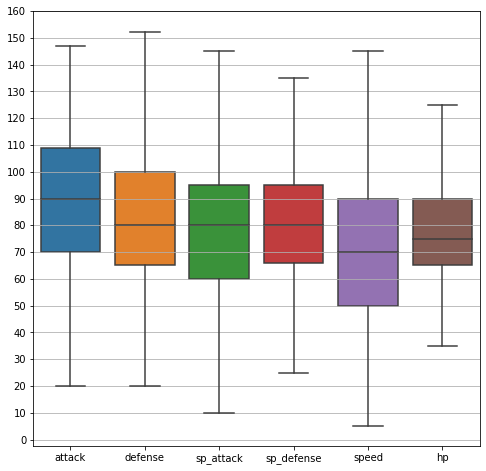

In [23]:
# Box plot of final form stats
plt.figure(figsize=(8,8))
sns.boxplot(data=final_forms.loc[:,stat_names],showfliers=False)
plt.grid(axis='y')
a = plt.yticks(np.arange(0,170,10))

# Pairwise pareto efficiency

In [24]:
# Add z scores of stats
final_forms = pokepareto.add_zscores(final_forms, stat_names)

In [55]:
# Make an interactive plot example of a two-stat pareto frontier
col1 = 'attack'
col2 = 'defense'
is_pareto = pokepareto.is_pareto_efficient(-final_forms.loc[:,[col1,col2]].values)
final_forms.loc[:,'2d_pareto'] = is_pareto

fig = px.scatter(data_frame=final_forms,
                 x=col1,
                 y=col2, 
                 hover_name='name',
                 color='2d_pareto',
                 hover_data={s:':.2f' for s in zstat_names},
                 title='Showing the pareto frontier for attack vs defense')
fig.update_layout(
    autosize=False,
    width=600,
    height=600,)
fig.show()

*Static snapshot of Plotly interactive plot:*
![](static_figs/example_2d_pareto.png)

In [26]:
pareto_table = []
for col1 in stat_names:
    for col2 in stat_names:
        is_pareto = pokepareto.is_pareto_efficient(-final_forms.loc[:,[col1,col2]].values)
        df = pd.DataFrame(final_forms.loc[:,['name',col1,col2]].values,columns=['name','stat1','stat2'])
        df.loc[:,'2d_pareto'] = is_pareto
        df.loc[:,'stat1_name'] = col1
        df.loc[:,'stat2_name'] = col2
        pareto_table.append(df)
        
pareto_table = pd.concat(pareto_table)

In [27]:
fig = px.scatter(data_frame=pareto_table,
                 x='stat1',
                 y='stat2', 
                 facet_col='stat1_name',
                 facet_row='stat2_name',
                 hover_name='name',
                 color='2d_pareto')
fig.update_layout(
    autosize=False,
    width=1000,
    height=1400,)
fig.show()

*Static snapshot of Plotly interactive plot:*
![](static_figs/all_2d_pareto.png)

# Determine which are on the pareto frontier

Example of pareto stats domination: the evolutions of Sobble (each generation is better along every stat)

In [28]:
all_ss[(all_ss.pokedex_number >= 7) & (all_ss.pokedex_number <= 9)].loc[:,['name']+stat_names]

,name,attack,defense,sp_attack,sp_defense,speed,hp


In [29]:
pareto_indexer = pokepareto.is_pareto_efficient(np.array(final_forms[stat_names])*-1)

final_forms.loc[:,'is_pareto'] = pareto_indexer

num_pareto = np.sum(final_forms.is_pareto)
print("%d Pokemon are pareto-efficient (%.1f%%)" % (num_pareto, 100*num_pareto/len(final_forms)))

143 Pokemon are pareto-efficient (69.8%)


In [30]:
pareto_only = final_forms[final_forms.is_pareto==True].copy()

# Add Z scores and total Z
Make sure to do this separately for each set of pokemon

In [31]:
all_ss = pokepareto.add_zscores(all_ss, stat_names)
final_forms = pokepareto.add_zscores(final_forms, stat_names)
pareto_only = pokepareto.add_zscores(pareto_only, stat_names)

# Embedding the final forms

In [32]:
embedding = umap.UMAP().fit_transform(final_forms.loc[:,stat_names])

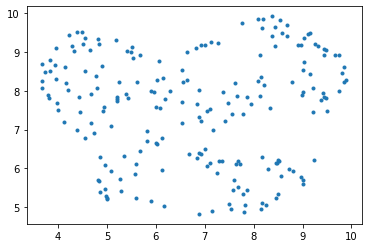

In [33]:
plt.plot(embedding[:,0],embedding[:,1],'.')

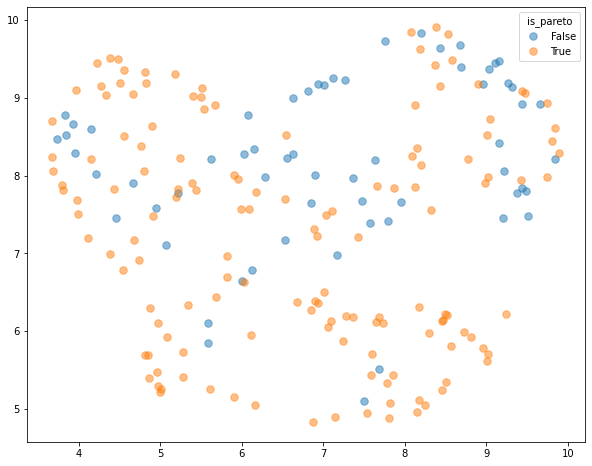

In [34]:
# Looking at embeddings of pareto and non pareto
plt.figure(figsize=(10,8))
col = 'is_pareto'
vals = np.unique(final_forms.loc[:,col])
for t in vals:
    plt.plot(embedding[final_forms.loc[:,col]==t,0],embedding[final_forms.loc[:,col]==t,1],'.',markersize=15,alpha=0.5)
plt.legend(vals,title=col)

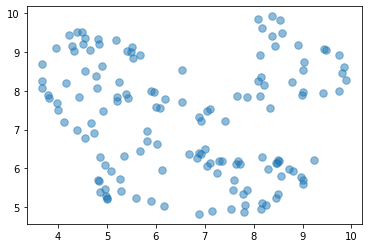

In [35]:
# Plotting only pareto embeddings
t=True
plt.plot(embedding[final_forms.is_pareto==t,0],embedding[final_forms.is_pareto==t,1],'.',markersize=15,alpha=0.5)


In [36]:
final_forms.loc[:,'emb_x'] = embedding[:,0]
final_forms.loc[:,'emb_y'] = embedding[:,1]

pareto_only = final_forms[final_forms.is_pareto==True].copy()
pareto_only = pokepareto.add_zscores(pareto_only,stat_names)

In [37]:
highest_stat = np.array(zstat_names)[np.argmax(pareto_only[zstat_names].values,axis=1)]


In [38]:
pareto_only.loc[:,'scaled_total_z'] = pareto_only.total_z.values - pareto_only.total_z.min()

In [39]:
pareto_only.loc[:,key_cols]

,name,pokedex_number,attack,defense,sp_attack,sp_defense,speed,hp,z_attack,z_defense,z_sp_attack,z_sp_defense,z_speed,z_hp


In [53]:
# Interactive graph of pareto efficient final forms, coloured by that pokemon's best stat (in z score terms)
fig = px.scatter(data_frame=pareto_only,
                 x='emb_x',
                 y='emb_y', 
                 hover_name='name',
                 color=highest_stat,
                 size='scaled_total_z',
                 hover_data={s:':.2f' for s in ['total_z'] + zstat_names},
                title="Pareto-efficient final forms embedded in 2D and coloured by highest stat (z score)")
fig.show()

*Static snapshot of Plotly interactive plot:*
![](static_figs/embedding_best_stat_coloured.png)

In [57]:
# Same graph but highlighting how the dimensions correlate with specific stats
thestat = 'attack'
fig = px.scatter(data_frame=pareto_only,
                 x='emb_x',
                 y='emb_y', 
                 hover_name='name',
                 color=thestat,
                 size='scaled_total_z',
                 hover_data={s:':.2f' for s in zstat_names},
                title="Pareto-efficient final forms embedded in 2D and coloured by attack")
fig.show()

*Static snapshot of Plotly interactive plot:*
![](static_figs/embedding_attack_coloured.png)

# Training recommendations`

A guide to picking pokemon to train by type, based on these criteria:
* Is pareto efficient
* Is not mythic or legendary
* Does not have more than 4 type vulnerabilities
* Does not have any super vulnerabilities (x4 vulnerability multipliers)

And then sorted in descending order by total_z (the sum of stat z scores)

In [42]:
cols = ['name','pokedex_number','type_1','type_2','base_species_name','total_z'] + stat_names

In [43]:
all_types = np.sort(final_forms.type_1.unique())

In [44]:
all_ss.loc[:,['name','type_1','type_2']+vul_cols]

name,type_1,type_2,vul_bug,vul_dark,vul_dragon,vul_electric,vul_fairy,vul_fighting,vul_fire,vul_ghost,vul_grass,vul_ground,vul_ice,vul_normal,vul_poison,vul_psychic,vul_rock,vul_steel,vul_water


In [45]:
max_vulnerabilities = 4
max_super_vulnerabilities = 0
for t in all_types:
    print('Top 5 pareto-efficient recommendations for what to train for ' + t + ' (by sum of z scores):')
    top_picks = pareto_only.loc[((pareto_only.type_1 == t) | (pareto_only.type_2 == t)) & ~pareto_only.is_legendary].copy()

    num_vulnerabilities = (top_picks.loc[:,vul_cols] > 1).sum(axis=1)
    num_super_vulnerabilities = (top_picks.loc[:,vul_cols] > 2).sum(axis=1)
    top_picks = top_picks[num_vulnerabilities <= max_vulnerabilities]
    top_picks = top_picks[num_super_vulnerabilities <= max_super_vulnerabilities]
    
    top_picks.sort_values('total_z',ascending=False, inplace=True)
    for i, row in top_picks.iloc[:5].iterrows():
        vuls = pokepareto.vulnerability_str(row, vul_cols)
        print("  {} (evolves into {} {:.3g})  {}".format(row.base_species_name, row.loc['name'], row.total_z, vuls))
    display(top_picks.loc[:,cols])

Top 5 pareto-efficient recommendations for what to train for bug (by sum of z scores):
  wimpod (evolves into golisopod 0.928)  Vulnerable to electric, flying, rock
  grubbin (evolves into vikavolt -0.187)  Vulnerable to fire, rock
  shuckle (evolves into shuckle -0.264)  Vulnerable to rock, steel, water
  shelmet (evolves into accelgor -0.394)  Vulnerable to fire, flying, rock
  dwebble (evolves into crustle -0.725)  Vulnerable to rock, steel, water


<ipython-input-45-770f02a0febb>:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp


Top 5 pareto-efficient recommendations for what to train for dark (by sum of z scores):
  eevee (evolves into umbreon 0.871)  Vulnerable to bug, fairy, fighting
  impidimp (evolves into grimmsnarl 0.435)  Vulnerable to fairy, poison, steel
  vullaby (evolves into mandibuzz 0.319)  Vulnerable to electric, fairy, ice, rock
  skorupi (evolves into drapion -0.274)  Vulnerable to ground
  stunky (evolves into skuntank -0.739)  Vulnerable to ground


<ipython-input-45-770f02a0febb>:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp


Top 5 pareto-efficient recommendations for what to train for dragon (by sum of z scores):
  goomy (evolves into goodra 3.66)  Vulnerable to dragon, fairy, ice
  axew (evolves into haxorus 1.32)  Vulnerable to dragon, fairy, ice
  duraludon (evolves into duraludon 0.862)  Vulnerable to fighting, ground
  dracozolt (evolves into dracozolt 0.0894)  Vulnerable to dragon, fairy, ground, ice
  dracovish (evolves into dracovish 0.0719)  Vulnerable to dragon, fairy


<ipython-input-45-770f02a0febb>:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp


Top 5 pareto-efficient recommendations for what to train for electric (by sum of z scores):
  eevee (evolves into jolteon 0.626)  Vulnerable to ground
  dracozolt (evolves into dracozolt 0.0894)  Vulnerable to dragon, fairy, ground, ice
  grubbin (evolves into vikavolt -0.187)  Vulnerable to fire, rock
  pichu (evolves into raichu -0.723)  Vulnerable to ground
  electrike (evolves into manectric -1.12)  Vulnerable to ground


,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp


Top 5 pareto-efficient recommendations for what to train for fairy (by sum of z scores):
  eevee (evolves into sylveon 0.978)  Vulnerable to poison, steel
  ralts (evolves into gardevoir 0.513)  Vulnerable to ghost, poison, steel
  impidimp (evolves into grimmsnarl 0.435)  Vulnerable to fairy, poison, steel
  hatenna (evolves into hatterene 0.197)  Vulnerable to ghost, poison, steel

<ipython-input-45-770f02a0febb>:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.




  ponyta (evolves into rapidash-galar -0.179)  Vulnerable to ghost, poison, steel


,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp


Top 5 pareto-efficient recommendations for what to train for fighting (by sum of z scores):
  riolu (evolves into lucario 0.721)  Vulnerable to fighting, fire, ground
  ralts (evolves into gallade 0.681)  Vulnerable to fairy, flying, ghost
  timburr (evolves into conkeldurr 0.291)  Vulnerable to fairy, flying, psychic
  stufful (evolves into bewear 0.162)  Vulnerable to fairy, fighting, flying, psychic
  farfetchd (evolves into sirfetchd 0.138)  Vulnerable to fairy, flying, psychic


<ipython-input-45-770f02a0febb>:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp


Top 5 pareto-efficient recommendations for what to train for fire (by sum of z scores):
  growlithe (evolves into arcanine 1.87)  Vulnerable to ground, rock, water
  scorbunny (evolves into cinderace 0.938)  Vulnerable to ground, rock, water
  eevee (evolves into flareon 0.93)  Vulnerable to ground, rock, water
  vulpix (evolves into ninetales 0.0309)  Vulnerable to ground, rock, water
  turtonator (evolves into turtonator -0.836)  Vulnerable to dragon, ground, rock


<ipython-input-45-770f02a0febb>:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp


Top 5 pareto-efficient recommendations for what to train for flying (by sum of z scores):
  rufflet (evolves into braviary 0.426)  Vulnerable to electric, ice, rock
  vullaby (evolves into mandibuzz 0.319)  Vulnerable to electric, fairy, ice, rock
  rookidee (evolves into corviknight -0.221)  Vulnerable to electric, fire
  pidove (evolves into unfezant -0.557)  Vulnerable to electric, ice, rock

<ipython-input-45-770f02a0febb>:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.




  hoothoot (evolves into noctowl -1.64)  Vulnerable to electric, ice, rock


,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp


Top 5 pareto-efficient recommendations for what to train for ghost (by sum of z scores):


<ipython-input-45-770f02a0febb>:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



  duskull (evolves into dusknoir 0.671)  Vulnerable to dark, ghost
  honedge (evolves into aegislash-shield 0.443)  Vulnerable to dark, fire, ghost, ground
  corsola (evolves into cursola 0.416)  Vulnerable to dark, ghost
  sinistea (evolves into polteageist 0.133)  Vulnerable to dark, ghost
  gastly (evolves into gengar -0.305)  Vulnerable to dark, ghost, ground, psychic


,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp


<ipython-input-45-770f02a0febb>:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



Top 5 pareto-efficient recommendations for what to train for grass (by sum of z scores):
  budew (evolves into roserade 0.335)  Vulnerable to fire, flying, ice, psychic
  oddish (evolves into vileplume -0.461)  Vulnerable to fire, flying, ice, psychic
  lotad (evolves into ludicolo -0.761)  Vulnerable to bug, flying, poison


,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp


Top 5 pareto-efficient recommendations for what to train for ground (by sum of z scores):
  hippopotas (evolves into hippowdon 0.887)  Vulnerable to grass, ice, water
  drilbur (evolves into excadrill 0.439)  Vulnerable to fighting, fire, ground, water
  mudbray (evolves into mudsdale 0.115)  Vulnerable to grass, ice, water
  silicobra (evolves into sandaconda 0.106)  Vulnerable to grass, ice, water
  onix (evolves into steelix -0.0768)  Vulnerable to fighting, fire, ground, water


<ipython-input-45-770f02a0febb>:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp


Top 5 pareto-efficient recommendations for what to train for ice (by sum of z scores):
  lapras (evolves into lapras 1.43)  Vulnerable to electric, fighting, grass, rock
  vanillite (evolves into vanilluxe 1.09)  Vulnerable to fighting, fire, rock, steel
  eevee (evolves into glaceon 0.574)  Vulnerable to fighting, fire, rock, steel
  shellder (evolves into cloyster 0.26)  Vulnerable to electric, fighting, grass, rock
  bergmite (evolves into avalugg 0.238)  Vulnerable to fighting, fire, rock, steel


<ipython-input-45-770f02a0febb>:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp


Top 5 pareto-efficient recommendations for what to train for normal (by sum of z scores):
  type-null (evolves into silvally 2.39)  Vulnerable to fighting
  munchlax (evolves into snorlax 1.95)  Vulnerable to fighting
  rufflet (evolves into braviary 0.426)  Vulnerable to electric, ice, rock
  stufful (evolves into bewear 0.162)  Vulnerable to fairy, fighting, flying, psychic
  oranguru (evolves into oranguru -0.367)  Vulnerable to bug, dark


,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp


Top 5 pareto-efficient recommendations for what to train for poison (by sum of z scores):
  budew (evolves into roserade 0.335)  Vulnerable to fire, flying, ice, psychic
  skorupi (evolves into drapion -0.274)  Vulnerable to ground
  gastly (evolves into gengar -0.305)  Vulnerable to dark, ghost, ground, psychic
  mareanie (evolves into toxapex -0.439)  Vulnerable to electric, ground, psychic
  oddish (evolves into vileplume -0.461)  Vulnerable to fire, flying, ice, psychic


,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp


Top 5 pareto-efficient recommendations for what to train for psychic (by sum of z scores):
  ralts (evolves into gallade 0.681)  Vulnerable to fairy, flying, ghost
  eevee (evolves into espeon 0.649)  Vulnerable to bug, dark, ghost
  ralts (evolves into gardevoir 0.513)  Vulnerable to ghost, poison, steel
  hatenna (evolves into hatterene 0.197)  Vulnerable to ghost, poison, steel
  bronzor (evolves into bronzong -0.102)  Vulnerable to dark, fire, ghost, ground


<ipython-input-45-770f02a0febb>:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp


Top 5 pareto-efficient recommendations for what to train for rock (by sum of z scores):
  shuckle (evolves into shuckle -0.264)  Vulnerable to rock, steel, water
  dwebble (evolves into crustle -0.725)  Vulnerable to rock, steel, water


<ipython-input-45-770f02a0febb>:10: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp


Top 5 pareto-efficient recommendations for what to train for steel (by sum of z scores):
  duraludon (evolves into duraludon 0.862)  Vulnerable to fighting, ground
  riolu (evolves into lucario 0.721)  Vulnerable to fighting, fire, ground
  honedge (evolves into aegislash-shield 0.443)  Vulnerable to dark, fire, ghost, ground
  drilbur (evolves into excadrill 0.439)  Vulnerable to fighting, fire, ground, water
  klink (evolves into klinklang 0.413)  Vulnerable to fighting, fire, ground


,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp


Top 5 pareto-efficient recommendations for what to train for water (by sum of z scores):
  lapras (evolves into lapras 1.43)  Vulnerable to electric, fighting, grass, rock
  feebas (evolves into milotic 1.41)  Vulnerable to electric, grass
  eevee (evolves into vaporeon 1.06)  Vulnerable to electric, grass
  wimpod (evolves into golisopod 0.928)  Vulnerable to electric, flying, rock
  sobble (evolves into inteleon 0.784)  Vulnerable to electric, grass


,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp


In [46]:
final_forms.loc[:,['is_pareto']+cols+zstat_names]

,is_pareto,name,pokedex_number,type_1,type_2,base_species_name,total_z,attack,defense,sp_attack,sp_defense,speed,hp,z_attack,z_defense,z_sp_attack,z_sp_defense,z_speed,z_hp


# Appendix: Pareto within types

In [47]:
all_paretos = []
for t in all_types:
    final_of_type = final_forms.loc[((final_forms.type_1 == t) | (final_forms.type_2 == t))].copy()

    pareto_indexer = pokepareto.is_pareto_efficient(np.array(final_of_type[stat_names])*-1)
    pareto_of_type = final_of_type[pareto_indexer]
    inefficent_str = ', '.join(final_of_type[~pareto_indexer].name)
    if len(inefficent_str) > 0:
        inefficent_str = 'Inefficient: ' + inefficent_str
    print("{}: {} of {} {}".format(t,len(pareto_of_type),len(final_of_type), inefficent_str))
    all_paretos.append(pareto_of_type)
    
pareto_by_type = pd.concat(all_paretos)

bug: 16 of 17 Inefficient: shedinja
dark: 13 of 19 Inefficient: shiftry, crawdaunt, pangoro, malamar, sableye, morpeko
dragon: 14 of 14 
electric: 14 of 15 Inefficient: heliolisk
fairy: 14 of 16 Inefficient: mawile, shiinotic
fighting: 18 of 19 Inefficient: falinks
fire: 12 of 12 
flying: 17 of 21 Inefficient: butterfree, delibird, xatu, swoobat
ghost: 18 of 20 Inefficient: froslass, shedinja
grass: 20 of 20 
ground: 17 of 18 Inefficient: quagsire
ice: 17 of 18 Inefficient: delibird
normal: 15 of 17 Inefficient: diggersby, ditto
poison: 12 of 12 
psychic: 23 of 23 
rock: 12 of 12 
steel: 16 of 17 Inefficient: mawile
water: 32 of 33 Inefficient: wishiwashi-solo


In [48]:
pareto_by_type = pareto_by_type.drop_duplicates()

In [49]:
len(pareto_by_type)

199

# To-do
* Info about Sword/Shield availability
* Many other nuances about pokemon types

### 